# Determine plane parameters from point picks in a KML file

Objective: determine plane parameters in geological coordinate frame from point picks in a kml file. Enable the use of multiple points, and store least square fit of plane as a measure of precision.

Method:

- Pick points in Google Earth (note: possibly pick multiple lines and store in different lines)
- Extract as kml file
- Download appropriate DEM (e.g. from https://earthexplorer.usgs.gov)
- Adapt script
- Check (!) plane fit


In [3]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import sys
from importlib import reload

%matplotlib inline

# own package to process files
sys.path.append(r"..")
import googlepicks
reload(googlepicks)

<module 'googlepicks' from '..\\googlepicks\\__init__.py'>

In [4]:
# k1 = kml_to_plane.KmlPoints(filename = "plane_picks.kml")
reload(googlepicks)
k1 = googlepicks.kml_to_plane.KmlPoints(filename = "../data/dome51_test_dips.kml", debug=True)
# k1 = kml_to_plane.KmlPoints(filename = "../data/dip1.kml", debug=True)

k1.point_sets[0]

read kml
5 point sets added


Point set with 11 points; latlong

In [5]:
# test if all point sets have at least three points:
print(len(k1.point_sets))
for ps in k1.point_sets:
    if len(ps.points) < 3:
        k1.point_sets.remove(ps)
        print("Removed point set")
print(len(k1.point_sets))


k1.point_sets[-1].points;

5
5


In [6]:
ps2 = k1.point_sets[2]

## Determine z-value and fit plane

In [7]:
for i, ps in enumerate(k1.point_sets):
    print(i, ps)

0 Point set with 11 points; latlong
1 Point set with 26 points; latlong
2 Point set with 67 points; latlong
3 Point set with 5 points; latlong
4 Point set with 6 points; latlong


In [8]:
for ps in k1.point_sets:  # loop over point sets
    try:
        ps.get_z_values_from_geotiff("../data/dome_sub_sub_utm.tif")
    except IndexError:
        print("Point outside geotiff, drop")
        k1.point_sets.remove(ps)
        continue
    ps.latlong_to_utm()
    ps.plane_fit()

## Determine dip and dip-direction from normal vector

In [9]:
# determine dip
def dip(normal_vec):
    return np.arccos(normal_vec[2]) / np.pi * 180.

dips = []

for ps in k1.point_sets:
    try:
        dips.append(dip(ps.normal))
    except AttributeError:
        k1.point_sets.remove(ps)
        print("Removed point set")
        
len(dips), len(k1.point_sets)


(5, 5)

In [10]:
# determine dip direction
def dip_dir(normal_vec):
    # +/+
    if normal_vec[0] >= 0 and normal_vec[1] > 0:
        return np.arctan(normal_vec[0]/normal_vec[1]) / np.pi * 180.
    # border cases where arctan not defined:
    elif normal_vec[0] > 0 and normal_vec[1] == 0:
        return 90
    elif normal_vec[0] < 0 and normal_vec[1] == 0:
        return 270
    # +-/-
    elif normal_vec[1] < 0:
        return 180 + np.arctan(normal_vec[0]/normal_vec[1]) / np.pi * 180.
    # -/-
    elif normal_vec[0] < 0 and normal_vec[1] >= 0:
        return 360 + np.arctan(normal_vec[0]/normal_vec[1]) / np.pi * 180.
#    elif normal_vec[1] == 0:
#        return 90

dip_dirs = []

for ps in k1.point_sets:
    try:
        dip_dirs.append(dip_dir(ps.normal))
    except AttributeError:
        k1.point_sets.remove(ps)
        print("Removed point set")
        
len(dips), len(k1.point_sets), len(dip_dirs)




#print(dip_dir(normal_vec))

(5, 5, 5)

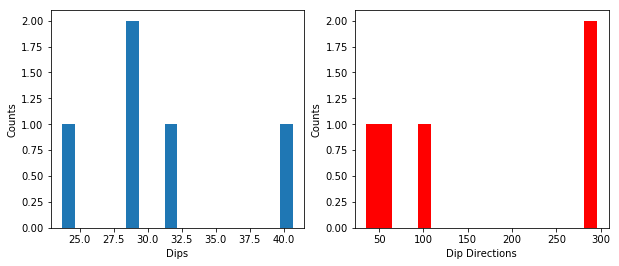

In [11]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.hist(dips, 18)
ax1.set_xlabel("Dips")
ax1.set_ylabel("Counts")
ax2.hist(dip_dirs, 18, color='r');
ax2.set_xlabel("Dip Directions")
ax2.set_ylabel("Counts")



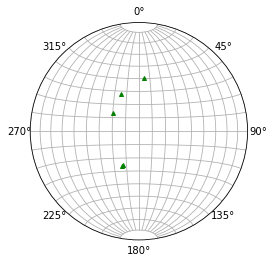

In [12]:
# plot all
import matplotlib.pyplot as plt
import mplstereonet

fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')

# ax.plane(dip_dirs, dips, 'g-', linewidth=0.5)
ax.pole(dip_dirs, dips, 'g^', markersize=4)
# ax.rake(strike, dip, -25)
ax.grid()

plt.show()

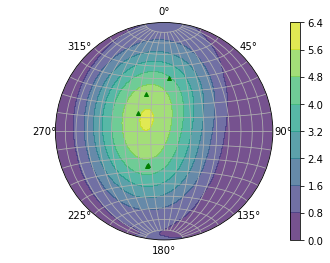

In [13]:
fig, ax = mplstereonet.subplots()

cax = ax.density_contourf(dip_dirs, dips, measurement='poles', cmap='viridis', alpha=0.75)

ax.pole(dip_dirs, dips, 'g^', markersize=4)

ax.grid(True)
fig.colorbar(cax)

plt.show()

In [14]:
vec = [-0.1,0.1,0.5]
dip_dir(vec/np.linalg.norm(vec)),dip(vec/np.linalg.norm(vec))

(315.0, 15.793169048263991)

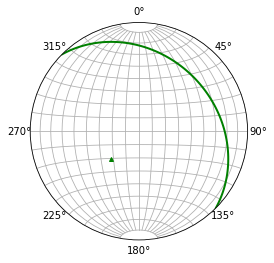

In [15]:
import matplotlib.pyplot as plt
import mplstereonet

fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')

strike, dip = 315, 30
ax.plane(strike, dip, 'g-', linewidth=2)
ax.pole(strike, dip, 'g^', markersize=4)
# ax.rake(strike, dip, -25)
ax.grid()

plt.show()

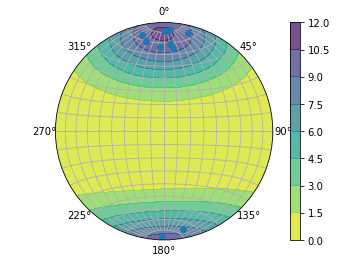

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import mplstereonet

fig, ax = mplstereonet.subplots()

strike, dip = 90, 80
num = 10
strikes = strike + 10 * np.random.randn(num)
dips = dip + 10 * np.random.randn(num)

cax = ax.density_contourf(strikes, dips, measurement='poles', cmap='viridis_r', alpha=0.75)

ax.pole(strikes, dips)
ax.grid(True)
fig.colorbar(cax)

plt.show()